In [1]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install matplotlib.pyplot
!{sys.executable} -m pip install glob
!{sys.executable} -m pip install sys
!{sys.executable} -m pip install mne

ERROR: Could not find a version that satisfies the requirement matplotlib.pyplot (from versions: none)
ERROR: No matching distribution found for matplotlib.pyplot
ERROR: Could not find a version that satisfies the requirement glob (from versions: none)
ERROR: No matching distribution found for glob
ERROR: Could not find a version that satisfies the requirement sys (from versions: none)
ERROR: No matching distribution found for sys


In [2]:
#Import libraries
import numpy as np # library for numerical calculations (similar to MATLAB), allows for vectorization and matrix operations
import pandas as pd # library for data analysis and manipulation
import matplotlib.pyplot as plt # library for plotting
import glob # library for file path manipulation
import sys # library for system-specific parameters and functions
import mne # library for EEG/MEG analysis

In [3]:
def find_crop_files(datapath='/media/large_disk/joshua/s_processed_data/', segment_type='baseline', dur=15.0, overlap=5.0):
    """
    Given a segment_type (baseline or followup) and a duration and overlap, finds the crop files for that segment type
    Inputs:
        datapath: path to the saved fif files containing EEG and ECG data
        segment_type: baseline or followup (default: baseline)
        dur: duration of the crop (default: 15.0)
        overlap: overlap of the crop (default: 5.0)
    """
    crop_files = glob.glob(f'{datapath}*/{segment_type}/crops/{segment_type}_dur{dur}_overlap{overlap}/*_raw.fif')
    return crop_files

# get all crop files
all_crop_files = find_crop_files()

In [72]:
test_subject_id = 166 # subject id to test
example_crop_file = [f for f in all_crop_files if str(test_subject_id) in f][0] # get the first crop file for the test subject id
test_raw = mne.io.read_raw_fif(example_crop_file, preload=True) # read in the crop file

Opening raw data file /media/large_disk/joshua/s_processed_data/166/baseline/crops/baseline_dur15.0_overlap5.0/eyes_closed1_cropdur15.0_relstart0.0_filtered_notch_60-120-180_l0.1_h235_baseline_166_raw.fif...
Isotrak not found
    Range : 37500 ... 45000 =     75.000 ...    90.000 secs
Ready.
Reading 0 ... 7500  =      0.000 ...    15.000 secs...


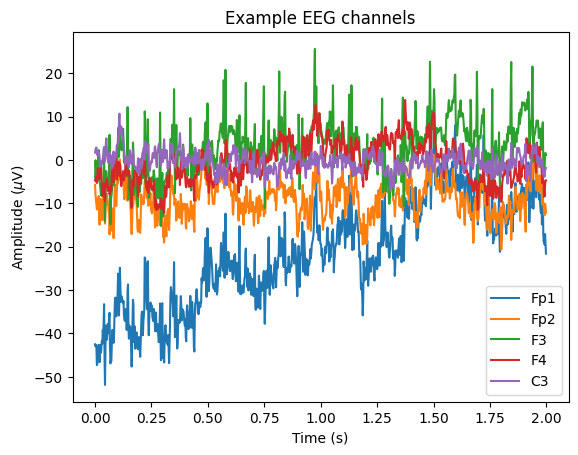

In [73]:
# plot the first 5 channels of the test crop file
plt.figure()
fs= 500 # sampling frequency
times  = np.arange(0, test_raw.get_data().shape[1], 1)/fs # time vector for plotting
max_time = 2 # maximum time to plot in seconds
for chan in range(0, 5):
    plt.plot(times[:max_time*fs], test_raw.get_data()[chan, :max_time*fs]*1e6, label=f'{test_raw.ch_names[chan]}')
    plt.xlabel('Time (s)')
    plt.ylabel(f'Amplitude ($\mu$V)')
    plt.legend()
    plt.title(f'Example EEG channels')

In [74]:
# load the csv file containing the start and stop times for the baseline and followup segments and also contains notates about the subjects ECG
filename="start_stop_annotations.csv" 
base_folder = '/home/joshua/Desktop/github/mTBI_FITBIR/'
start_stop_annotations = pd.read_csv(base_folder+filename).sort_values(by=['Recording Index'])
start_stop_annotations.head()

,Recording Index,Study ID,EYES CLOSED START 1,EYES CLOSED END 1,EYES OPEN START 1,EYES OPEN END 1,EYES CLOSED START 2,EYES CLOSED END 2,EYES OPEN START 2,EYES OPEN END 2,ECG Location,Notes,Notes2,closed 3,closed 3.1,open 3,open 3,ECG NOTES,ECG Approved
7,0.0,20.0,454.0,510.0,148.0,211.0,622.0,681.0,540.0,600.0,X1,NaN,NaN,NaN,NaN,NaN,NaN,Clean,NaN
30,1.0,66.0,167.0,196.0,118.0,148.0,255.0,270.0,211.0,240.0,X2,high freq noise throughout channels,shorter second eyes closed,NaN,NaN,NaN,NaN,Clean,NaN
14,2.0,31.0,275.0,338.0,219.0,258.0,485.0,529.0,355.0,388.0,X1,NaN,NaN,NaN,NaN,NaN,NaN,Clean,NaN
67,3.0,166.0,75.0,106.0,120.0,150.0,170.0,204.0,220.0,256.0,X1,continuous alpha shortened (0.5 seconds -- err...,"artifact from 246-251, might separate w psd/mtbi",NaN,NaN,NaN,NaN,Clean,NaN
61,4.0,154.0,207.0,254.0,121.0,149.0,NaN,NaN,151.0,171.0,X1,NaN,NaN,NaN,NaN,NaN,NaN,Clean,NaN


In [75]:
# ECG locations
ecg_locations = start_stop_annotations[['Study ID', 'ECG Location']].dropna()
ecg_locations

,Study ID,ECG Location
7,20.0,X1
30,66.0,X2
14,31.0,X1
67,166.0,X1
61,154.0,X1
...,...,...
62,155.0,X1
49,123.0,X2
64,159.0,X1
1,5.0,X1


In [76]:
# ECG location for the test subject
test_ecg_location = ecg_locations[ecg_locations['Study ID']==test_subject_id]['ECG Location'].values[0]
test_ecg_location

'X1'

ECG data shape: (1, 7501)


Text(0.5, 1.0, 'ECG data for subject 166')

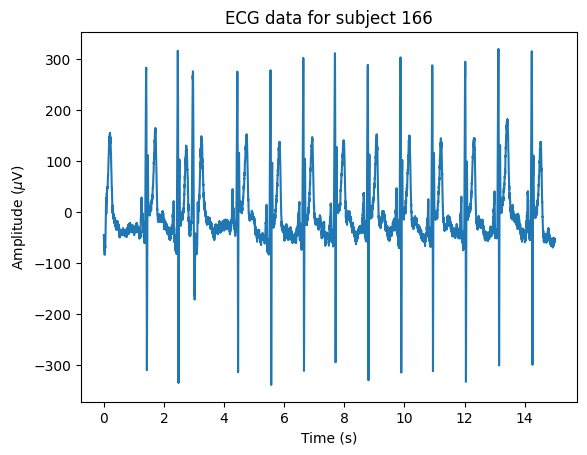

In [77]:
# get the channel in the test raw file that corresponds to the ECG location
ecg_data = test_raw.copy().get_data(picks=test_ecg_location)
print(f'ECG data shape: {ecg_data.shape}')

plt.figure()
plt.plot(times[:], ecg_data[0, :]*1e6)
plt.xlabel('Time (s)')
plt.ylabel(f'Amplitude ($\mu$V)')
plt.title(f'ECG data for subject {test_subject_id}')

In [78]:
!{sys.executable} -m pip install git+https://github.com/jtlait/ecg2rr.git#egg=ecg2rr
from ecg2rr import detector

#initialize detector
dt = detector.ECG_detector(
    sampling_rate=500,
    stride=250,
    threshold=0.05
)

  Cloning https://github.com/jtlait/ecg2rr.git to /tmp/pip-install-31c7rw7i/ecg2rr_ff16fc4daba0424a9e24fa0d7b0e7fd9
  Running command git clone --filter=blob:none --quiet https://github.com/jtlait/ecg2rr.git /tmp/pip-install-31c7rw7i/ecg2rr_ff16fc4daba0424a9e24fa0d7b0e7fd9
  Resolved https://github.com/jtlait/ecg2rr.git to commit b642cb388f0f11c8f4700754f2fc402ee81e5b91
  Preparing metadata (setup.py) ... done


In [87]:
import scipy
from scipy import signal

max_hr = 200 # bpm 
min_spacing = 60/max_hr # seconds
ys = np.sin(2*np.pi * 1.0 * ts)  # signal @ 1.0 Hz, without noise
yerr = 0.5 * np.random.normal(size=len(ts))  # Gaussian noise
yraw = ys + yer
peaks = scipy.signal.find_peaks_cwt(yraw, widths=np.arange(5, 15))

filtered_peaks = dt.remove_close(peaks=peaks, peak_probs=probs, threshold_ms=500)

AssertionError: 

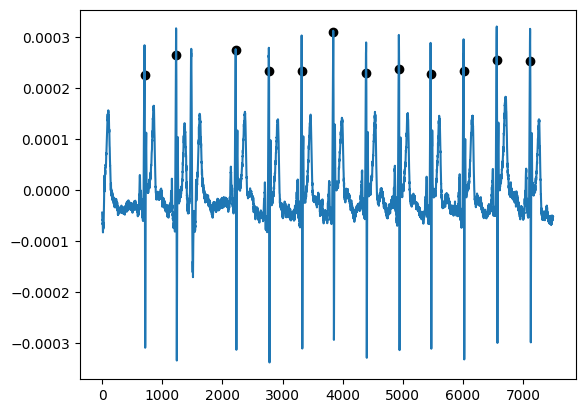

In [80]:
# Plot found R-peaks with the ECG signal
plt.plot(ecg_data[0][:8000])
plt.scatter(x=filtered_peaks[:100], y=ecg_data[0][filtered_peaks[:100]], color='black')

Text(0.5, 1.0, 'ECG peaks')

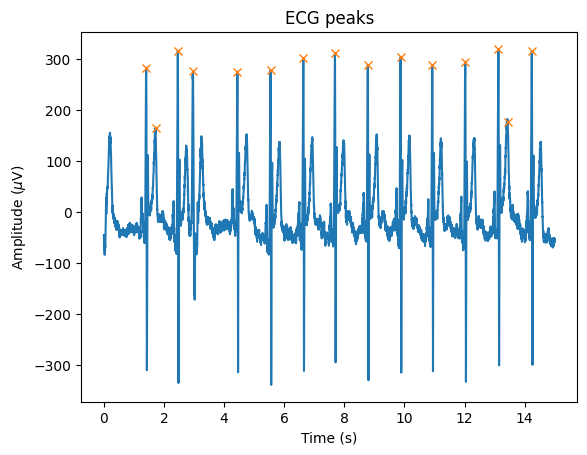

In [88]:
max_hr = 200 # bpm 
min_spacing = 60/max_hr # seconds
peaks, _ = signal.find_peaks(ecg_data[0, :], distance=min_spacing*fs, height=0.5*np.max(ecg_data[0, :]))
plt.figure()
plt.plot(times[:], ecg_data[0, :]*1e6)
plt.plot(times[peaks], ecg_data[0, peaks]*1e6, "x")
plt.xlabel('Time (s)')
plt.ylabel(f'Amplitude ($\mu$V)')
plt.title('ECG peaks')


In [82]:
def extract_all_rpeaks():
    """
    Some function to extract all the R peaks for all the subjects and all the files for each subject
    """
    pass

In [83]:
def extract_all_hrv_features():
    """
    Some function to extract all the HRV features for all the subjects and all the files for each subject
    """
    pass